#**A. Pre-Requisites**

1. Kaggle Installation

In [ ]:
%%capture
!pip install kaggle

2. Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/COMP700/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

# **B. Install the Required Libraries**

In [ ]:
%%capture

# SAM
!pip install git+https://github.com/facebookresearch/segment-anything.git

# Transformers
!pip install -q git+https://github.com/huggingface/transformers.git

# Datasets to prepare data and monai if you want to use special loss functions
!pip install datasets
!pip install -q monai

# Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)
!pip install patchify
!pip install nibabel

# **Datasets**

# **1. BUSI Synthetic Dataset**

Breast Ultrasound Synthetic

## Download Dataset

In [ ]:
!kaggle datasets download jocelyndumlao/bus-synthetic-dataset
!unzip -q bus-synthetic-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/jocelyndumlao/bus-synthetic-dataset
License(s): CC0-1.0
100% 9.72M/9.72M [00:00<00:00, 39.8MB/s]
100% 9.72M/9.72M [00:00<00:00, 40.1MB/s]


## Create Dataset

In [ ]:
import os
import numpy as np
from PIL import Image
from patchify import patchify
from datasets import Dataset

# Define paths to the directories containing .PNG images
image_dir = '/content/BUS Synthetic Dataset/BUS_synthetic_dataset/images'  # Directory with image .png files
mask_dir = '/content/BUS Synthetic Dataset/BUS_synthetic_dataset/masks'    # Directory with mask .png files

# Desired patch size and step size
patch_size = 256
step = 256
resize_to = (256, 256)  # Define a common size for all images and masks

# Function to load and resize images from a folder
def load_images_from_folder(folder, target_size):
    images = []
    for filename in sorted(os.listdir(folder)):  # Sorting ensures consistent order
        if filename.endswith('.png') or filename.endswith('.jpg'):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).convert('L')  # Convert to grayscale
            img = img.resize(target_size)  # Resize to the target size
            img_np = np.array(img)
            images.append(img_np)
    return np.array(images)

# Load and resize images and masks
large_images = load_images_from_folder(image_dir, resize_to)
large_masks = load_images_from_folder(mask_dir, resize_to)

# Check loaded image and mask shapes
print(f"Loaded {large_images.shape[0]} images of shape {large_images.shape[1:]} (HxW)")
print(f"Loaded {large_masks.shape[0]} masks of shape {large_masks.shape[1:]} (HxW)")

# Extract patches for images
all_img_patches = []
for img in range(large_images.shape[0]):
    large_image = large_images[img]
    patches_img = patchify(large_image, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            single_patch_img = patches_img[i, j, :, :]
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)

# Extract patches for masks
all_mask_patches = []
for img in range(large_masks.shape[0]):
    large_mask = large_masks[img]
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            single_patch_mask = patches_mask[i, j, :, :]
            single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)  # Normalize to 0-1 range
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)

# Filter non-empty masks and corresponding images
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]

# Print the shapes of the filtered image and mask arrays
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width)
print("Mask shape:", filtered_masks.shape)

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)


Loaded 500 images of shape (256, 256) (HxW)
Loaded 500 masks of shape (256, 256) (HxW)
Image shape: (500, 256, 256)
Mask shape: (500, 256, 256)


In [ ]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 500
})

## Save Dataset

In [ ]:
from google.colab import drive
import numpy as np
import pickle

drive.mount('/content/drive')

# Save as .npz
#np.savez('/content/drive/MyDrive/COMP700/EfficientSAM/kvasir_dataset.npz', images=images, labels=labels)

# Save as pickle file
with open('/content/drive/MyDrive/COMP700/EfficientSAM/busi_synthetic_dataset.pkl', 'wb') as f:
    pickle.dump(dataset_dict, f)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load Dataset

In [ ]:
import pickle
from datasets import Dataset
from google.colab import drive

#drive.mount('/content/drive')

# Reload the dataset dictionary from pickle
with open('/content/drive/MyDrive/COMP700/EfficientSAM/busi_synthetic_dataset.pkl', 'rb') as f:
    dataset_dict = pickle.load(f)

# Recreate the Dataset object
dataset = Dataset.from_dict(dataset_dict)

dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 500
})

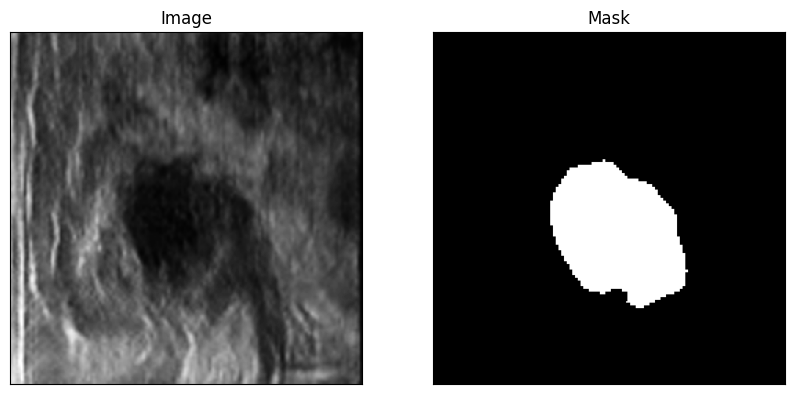

In [ ]:
import random  # Import the random module
import matplotlib.pyplot as plt
import numpy as np

img_num = random.randint(0, len(dataset)-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

# **2. Glaucoma Fundus Imaging Dataset**

Contains the following 3 datasets:


*   G1020
*   ORIGA
*   REFUGE



## Download Dataset

In [ ]:
!kaggle datasets download arnavjain1/glaucoma-datasets
!unzip -q glaucoma-datasets.zip

Dataset URL: https://www.kaggle.com/datasets/arnavjain1/glaucoma-datasets
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
100% 5.54G/5.55G [01:18<00:00, 74.0MB/s]
100% 5.55G/5.55G [01:18<00:00, 75.9MB/s]


## 2.3. REFUGE Dataset

### Create Dataset

In [ ]:
import os
import numpy as np
from PIL import Image
from patchify import patchify
from datasets import Dataset

# Define paths to the directories containing images and masks
image_dir = '/content/REFUGE/train/illustrations'  # Directory with image .png or .jpg files
mask_dir = '/content/REFUGE/train/gts'  # Directory with mask .bmp files

# Desired patch size and step size
patch_size = 256
step = 256
resize_to = (256, 256)  # Define a common size for all images and masks

# Function to load and resize images from a folder
def load_images_from_folder(folder, target_size, file_extensions=('.png', '.jpg', '.bmp')):
    images = []
    for filename in sorted(os.listdir(folder)):  # Sorting ensures consistent order
        if filename.lower().endswith(file_extensions):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).convert('L')  # Convert to grayscale
            img = img.resize(target_size)  # Resize to the target size
            img_np = np.array(img)
            images.append(img_np)
    return np.array(images)

# Load and resize images and masks
large_images = load_images_from_folder(image_dir, resize_to)  # Load images (.png/.jpg)
large_masks = load_images_from_folder(mask_dir, resize_to, file_extensions=('.bmp',))  # Load masks (.bmp)

# Check loaded image and mask shapes
print(f"Loaded {large_images.shape[0]} images of shape {large_images.shape[1:]} (HxW)")
print(f"Loaded {large_masks.shape[0]} masks of shape {large_masks.shape[1:]} (HxW)")

# Extract patches for images
all_img_patches = []
for img in range(large_images.shape[0]):
    large_image = large_images[img]
    patches_img = patchify(large_image, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            single_patch_img = patches_img[i, j, :, :]
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)

# Extract patches for masks
all_mask_patches = []
for img in range(large_masks.shape[0]):
    large_mask = large_masks[img]
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            single_patch_mask = patches_mask[i, j, :, :]
            single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)  # Normalize to 0-1 range
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)

# Filter non-empty masks and corresponding images
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]

# Print the shapes of the filtered image and mask arrays
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width)
print("Mask shape:", filtered_masks.shape)

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)


Loaded 400 images of shape (256, 256) (HxW)
Loaded 400 masks of shape (256, 256) (HxW)
Image shape: (400, 256, 256)
Mask shape: (400, 256, 256)


In [ ]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 400
})

### Save Dataset

In [ ]:
from google.colab import drive
import numpy as np
import pickle

drive.mount('/content/drive')

# Save as .npz
#np.savez('/content/drive/MyDrive/COMP700/EfficientSAM/kvasir_dataset.npz', images=images, labels=labels)

# Save as pickle file
with open('/content/drive/MyDrive/COMP700/EfficientSAM/refuge_dataset.pkl', 'wb') as f:
    pickle.dump(dataset_dict, f)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load Dataset

In [ ]:
import pickle
from datasets import Dataset
from google.colab import drive

#drive.mount('/content/drive')

# Reload the dataset dictionary from pickle
with open('/content/drive/MyDrive/COMP700/EfficientSAM/refuge_dataset.pkl', 'rb') as f:
    dataset_dict = pickle.load(f)

# Recreate the Dataset object
dataset = Dataset.from_dict(dataset_dict)

dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 400
})

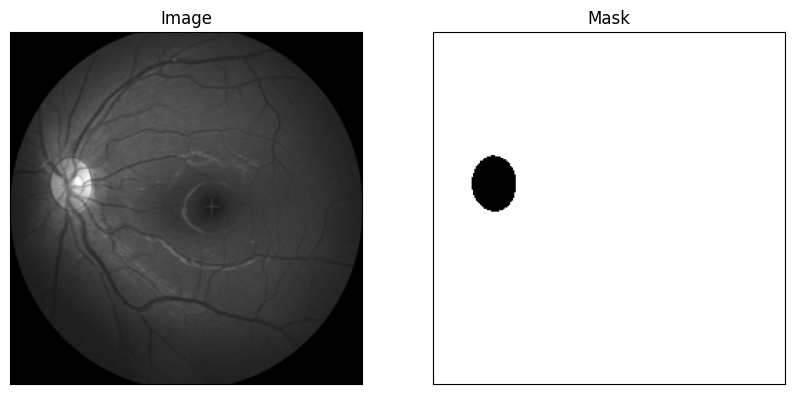

In [ ]:
import random  # Import the random module
import matplotlib.pyplot as plt
import numpy as np

img_num = random.randint(0, len(dataset)-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

# **3. Abdominal Organ Segmentation Dataset**

## Download Dataset

In [ ]:
!kaggle datasets download monirulhaquebracu/abdominal-organ-segmentation-dataset
!unzip -q abdominal-organ-segmentation-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/monirulhaquebracu/abdominal-organ-segmentation-dataset
License(s): CC-BY-SA-4.0
100% 1.90G/1.90G [00:27<00:00, 111MB/s]
100% 1.90G/1.90G [00:27<00:00, 75.4MB/s]


## Create Dataset

In [ ]:
import os
import numpy as np
from PIL import Image
from patchify import patchify
from datasets import Dataset

# Define path to the main training directory containing subfolders with images and masks
train_dir = '/content/split_organized/train'  # Parent directory with image and mask folders

# Desired patch size and step size
patch_size = 256
step = 256
resize_to = (256, 256)  # Define a common size for all images and masks

# Function to load and resize a single image from the image folder
def load_image_from_folder(folder, target_size):
    image_files = [f for f in sorted(os.listdir(folder)) if f.endswith('.png') or f.endswith('.jpg')]
    if image_files:  # Ensure there's at least one image file
        img_path = os.path.join(folder, image_files[0])  # Take the first image
        img = Image.open(img_path).convert('L')  # Convert to grayscale
        img = img.resize(target_size)  # Resize to the target size
        return np.array(img)
    return None

# Function to load and resize multiple masks from the mask folder
def load_masks_from_folder(folder, target_size):
    masks = []
    for filename in sorted(os.listdir(folder)):  # Sorting ensures consistent order
        if filename.endswith('.png') or filename.endswith('.bmp'):
            mask_path = os.path.join(folder, filename)
            mask = Image.open(mask_path).convert('L')  # Convert to grayscale
            mask = mask.resize(target_size)  # Resize to the target size
            mask_np = np.array(mask)
            masks.append(mask_np)
    return np.array(masks)

# Loop through each subfolder in the train directory to load images and masks
all_img_patches = []
all_mask_patches = []

for folder_name in sorted(os.listdir(train_dir)):
    folder_path = os.path.join(train_dir, folder_name)

    # Check if it's a directory and contains the required subfolders
    if os.path.isdir(folder_path):
        image_subfolder = os.path.join(folder_path, 'images')
        mask_subfolder = os.path.join(folder_path, 'masks')

        if os.path.exists(image_subfolder) and os.path.exists(mask_subfolder):
            # Load and resize the image
            large_image = load_image_from_folder(image_subfolder, resize_to)
            if large_image is not None:
                # Extract patches for the image
                patches_img = patchify(large_image, (patch_size, patch_size), step=step)  # No overlap
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        single_patch_img = patches_img[i, j, :, :]
                        all_img_patches.append(single_patch_img)

                # Load and resize masks, then extract patches for each mask
                large_masks = load_masks_from_folder(mask_subfolder, resize_to)
                for large_mask in large_masks:
                    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  # No overlap
                    for i in range(patches_mask.shape[0]):
                        for j in range(patches_mask.shape[1]):
                            single_patch_mask = patches_mask[i, j, :, :]
                            single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)  # Normalize to 0-1 range
                            all_mask_patches.append(single_patch_mask)

# Convert all patches to arrays
images = np.array(all_img_patches)
masks = np.array(all_mask_patches)

# Check the number of patches for images and masks
print(f"Number of image patches: {len(images)}")
print(f"Number of mask patches: {len(masks)}")

# Handle mismatch by adjusting valid indices to the smaller size
min_patches = min(len(images), len(masks))
images = images[:min_patches]
masks = masks[:min_patches]

# Filter non-empty masks and corresponding images
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]

# Print the shapes of the filtered image and mask arrays
print("Filtered image shape:", filtered_images.shape)  # e.g., (num_frames, height, width)
print("Filtered mask shape:", filtered_masks.shape)

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)


Number of image patches: 1144
Number of mask patches: 8008
Filtered image shape: (459, 256, 256)
Filtered mask shape: (459, 256, 256)


In [ ]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 459
})

## Save Dataset

In [ ]:
from google.colab import drive
import numpy as np
import pickle

drive.mount('/content/drive')

# Save as .npz
#np.savez('/content/drive/MyDrive/COMP700/EfficientSAM/kvasir_dataset.npz', images=images, labels=labels)

# Save as pickle file
with open('/content/drive/MyDrive/COMP700/EfficientSAM/abdominal_organseg_dataset.pkl', 'wb') as f:
    pickle.dump(dataset_dict, f)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load Dataset

In [ ]:
import pickle
from datasets import Dataset
from google.colab import drive

#drive.mount('/content/drive')

# Reload the dataset dictionary from pickle
with open('/content/drive/MyDrive/COMP700/EfficientSAM/abdominal_organseg_dataset.pkl', 'rb') as f:
    dataset_dict = pickle.load(f)

# Recreate the Dataset object
dataset = Dataset.from_dict(dataset_dict)

dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 459
})

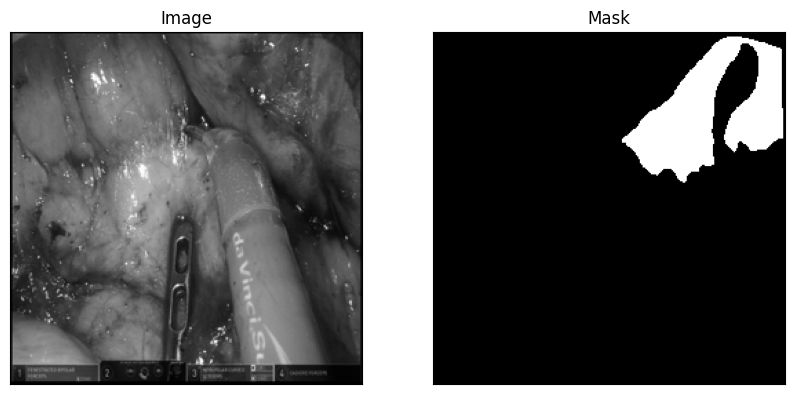

In [ ]:
import random  # Import the random module
import matplotlib.pyplot as plt
import numpy as np

img_num = random.randint(0, len(dataset)-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

# **4. PROMISE12 Dataset**

Prostate MRI Segmentation

## Download Dataset

In [ ]:
!kaggle datasets download tushartalukder/medical-image-segmentation-datasets-hi-gmisnet
!unzip -q medical-image-segmentation-datasets-hi-gmisnet.zip

Dataset URL: https://www.kaggle.com/datasets/tushartalukder/medical-image-segmentation-datasets-hi-gmisnet
License(s): MIT
100% 1.70G/1.70G [00:57<00:00, 31.5MB/s]
100% 1.70G/1.70G [00:57<00:00, 32.0MB/s]


## Create Dataset

In [ ]:
import os
import numpy as np
from PIL import Image
from patchify import patchify
from datasets import Dataset

# Define paths to the directories containing .PNG images
image_dir = '/content/Hi-gMISnet_all_dataset/PROMISE12/train_data/image'  # Directory with image .png files
mask_dir = '/content/Hi-gMISnet_all_dataset/PROMISE12/train_data/mask'    # Directory with mask .png files

# Desired patch size and step size
patch_size = 256
step = 256
resize_to = (256, 256)  # Define a common size for all images and masks

# Function to load and resize images from a folder
def load_images_from_folder(folder, target_size):
    images = []
    for filename in sorted(os.listdir(folder)):  # Sorting ensures consistent order
        if filename.endswith('.png') or filename.endswith('.jpg'):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).convert('L')  # Convert to grayscale
            img = img.resize(target_size)  # Resize to the target size
            img_np = np.array(img)
            images.append(img_np)
    return np.array(images)

# Load and resize images and masks
large_images = load_images_from_folder(image_dir, resize_to)
large_masks = load_images_from_folder(mask_dir, resize_to)

# Check loaded image and mask shapes
print(f"Loaded {large_images.shape[0]} images of shape {large_images.shape[1:]} (HxW)")
print(f"Loaded {large_masks.shape[0]} masks of shape {large_masks.shape[1:]} (HxW)")

# Extract patches for images
all_img_patches = []
for img in range(large_images.shape[0]):
    large_image = large_images[img]
    patches_img = patchify(large_image, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            single_patch_img = patches_img[i, j, :, :]
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)

# Extract patches for masks
all_mask_patches = []
for img in range(large_masks.shape[0]):
    large_mask = large_masks[img]
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            single_patch_mask = patches_mask[i, j, :, :]
            single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)  # Normalize to 0-1 range
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)

# Filter non-empty masks and corresponding images
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]

# Print the shapes of the filtered image and mask arrays
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width)
print("Mask shape:", filtered_masks.shape)

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)


Loaded 778 images of shape (256, 256) (HxW)
Loaded 778 masks of shape (256, 256) (HxW)
Image shape: (778, 256, 256)
Mask shape: (778, 256, 256)


In [ ]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 778
})

## Save Dataset

In [ ]:
from google.colab import drive
import numpy as np
import pickle

drive.mount('/content/drive')

# Save as .npz
#np.savez('/content/drive/MyDrive/COMP700/EfficientSAM/kvasir_dataset.npz', images=images, labels=labels)

# Save as pickle file
with open('/content/drive/MyDrive/COMP700/EfficientSAM/promise_dataset.pkl', 'wb') as f:
    pickle.dump(dataset_dict, f)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load Dataset

In [ ]:
import pickle
from datasets import Dataset
from google.colab import drive

#drive.mount('/content/drive')

# Reload the dataset dictionary from pickle
with open('/content/drive/MyDrive/COMP700/EfficientSAM/promise_dataset.pkl', 'rb') as f:
    dataset_dict = pickle.load(f)

# Recreate the Dataset object
dataset = Dataset.from_dict(dataset_dict)

dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 778
})

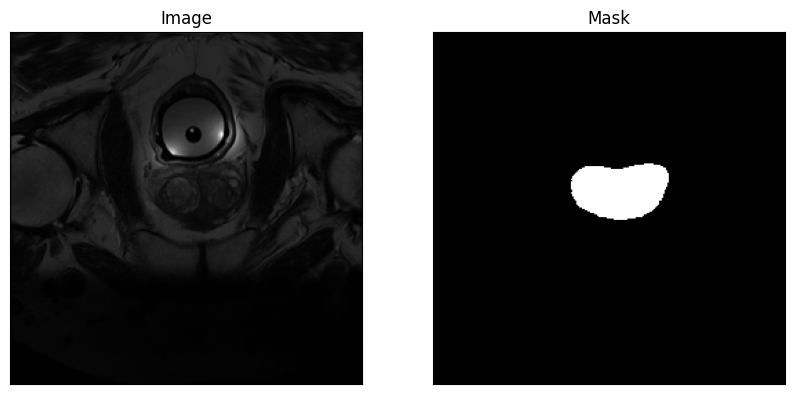

In [ ]:
import random  # Import the random module
import matplotlib.pyplot as plt
import numpy as np

img_num = random.randint(0, len(dataset)-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

# **5. ISIC2018 Dataset**

Internal Skin Imaging Collaboration

## Download Dataset

In [ ]:
!kaggle datasets download tushartalukder/medical-image-segmentation-datasets-hi-gmisnet
!unzip -q medical-image-segmentation-datasets-hi-gmisnet.zip

Dataset URL: https://www.kaggle.com/datasets/tushartalukder/medical-image-segmentation-datasets-hi-gmisnet
License(s): MIT
100% 1.70G/1.70G [00:57<00:00, 31.5MB/s]
100% 1.70G/1.70G [00:57<00:00, 32.0MB/s]


## Create Dataset

In [ ]:
import os
import numpy as np
from PIL import Image
from patchify import patchify
from datasets import Dataset

# Define paths to the directories containing .PNG images
image_dir = '/content/Hi-gMISnet_all_dataset/ISIC_2018/train_folder/img'  # Directory with image .png files
mask_dir = '/content/Hi-gMISnet_all_dataset/ISIC_2018/train_folder/label'    # Directory with mask .png files

# Desired patch size and step size
patch_size = 256
step = 256
resize_to = (256, 256)  # Define a common size for all images and masks

# Function to load and resize images from a folder
def load_images_from_folder(folder, target_size):
    images = []
    for filename in sorted(os.listdir(folder)):  # Sorting ensures consistent order
        if filename.endswith('.png') or filename.endswith('.jpg'):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).convert('L')  # Convert to grayscale
            img = img.resize(target_size)  # Resize to the target size
            img_np = np.array(img)
            images.append(img_np)
    return np.array(images)

# Load and resize images and masks
large_images = load_images_from_folder(image_dir, resize_to)
large_masks = load_images_from_folder(mask_dir, resize_to)

# Check loaded image and mask shapes
print(f"Loaded {large_images.shape[0]} images of shape {large_images.shape[1:]} (HxW)")
print(f"Loaded {large_masks.shape[0]} masks of shape {large_masks.shape[1:]} (HxW)")

# Extract patches for images
all_img_patches = []
for img in range(large_images.shape[0]):
    large_image = large_images[img]
    patches_img = patchify(large_image, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            single_patch_img = patches_img[i, j, :, :]
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)

# Extract patches for masks
all_mask_patches = []
for img in range(large_masks.shape[0]):
    large_mask = large_masks[img]
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            single_patch_mask = patches_mask[i, j, :, :]
            single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)  # Normalize to 0-1 range
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)

# Filter non-empty masks and corresponding images
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]

# Print the shapes of the filtered image and mask arrays
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width)
print("Mask shape:", filtered_masks.shape)

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)


Loaded 2074 images of shape (256, 256) (HxW)
Loaded 2074 masks of shape (256, 256) (HxW)
Image shape: (2074, 256, 256)
Mask shape: (2074, 256, 256)


In [ ]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 2074
})

## Save Dataset

In [ ]:
from google.colab import drive
import numpy as np
import pickle

drive.mount('/content/drive')

# Save as .npz
#np.savez('/content/drive/MyDrive/COMP700/EfficientSAM/kvasir_dataset.npz', images=images, labels=labels)

# Save as pickle file
with open('/content/drive/MyDrive/COMP700/EfficientSAM/isic_dataset.pkl', 'wb') as f:
    pickle.dump(dataset_dict, f)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load Dataset

In [ ]:
import pickle
from datasets import Dataset
from google.colab import drive

#drive.mount('/content/drive')

# Reload the dataset dictionary from pickle
with open('/content/drive/MyDrive/COMP700/EfficientSAM/isic_dataset.pkl', 'rb') as f:
    dataset_dict = pickle.load(f)

# Recreate the Dataset object
dataset = Dataset.from_dict(dataset_dict)

dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 2074
})

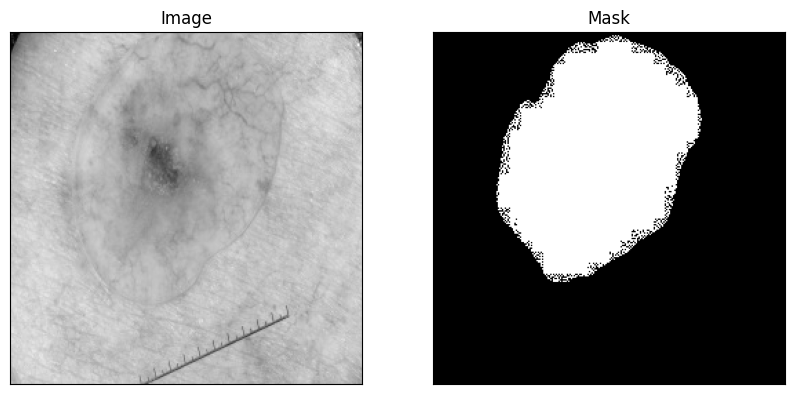

In [ ]:
import random  # Import the random module
import matplotlib.pyplot as plt
import numpy as np

img_num = random.randint(0, len(dataset)-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

# **6. Montgomery County Dataset**

Chest X-Ray

## Download Dataset

In [ ]:
!kaggle datasets download tushartalukder/medical-image-segmentation-datasets-hi-gmisnet
!unzip -q medical-image-segmentation-datasets-hi-gmisnet.zip

Dataset URL: https://www.kaggle.com/datasets/tushartalukder/medical-image-segmentation-datasets-hi-gmisnet
License(s): MIT
100% 1.70G/1.70G [00:57<00:00, 31.5MB/s]
100% 1.70G/1.70G [00:57<00:00, 32.0MB/s]


## Create Dataset

In [ ]:
import os
import numpy as np
from PIL import Image
from patchify import patchify
from datasets import Dataset

# Define paths to the directories containing .PNG images
image_dir = '/content/Hi-gMISnet_all_dataset/Montgomery_County/train_folder/img'  # Directory with image .png files
mask_dir = '/content/Hi-gMISnet_all_dataset/Montgomery_County/train_folder/label'    # Directory with mask .png files

# Desired patch size and step size
patch_size = 256
step = 256
resize_to = (256, 256)  # Define a common size for all images and masks

# Function to load and resize images from a folder
def load_images_from_folder(folder, target_size):
    images = []
    for filename in sorted(os.listdir(folder)):  # Sorting ensures consistent order
        if filename.endswith('.png') or filename.endswith('.jpg'):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).convert('L')  # Convert to grayscale
            img = img.resize(target_size)  # Resize to the target size
            img_np = np.array(img)
            images.append(img_np)
    return np.array(images)

# Load and resize images and masks
large_images = load_images_from_folder(image_dir, resize_to)
large_masks = load_images_from_folder(mask_dir, resize_to)

# Check loaded image and mask shapes
print(f"Loaded {large_images.shape[0]} images of shape {large_images.shape[1:]} (HxW)")
print(f"Loaded {large_masks.shape[0]} masks of shape {large_masks.shape[1:]} (HxW)")

# Extract patches for images
all_img_patches = []
for img in range(large_images.shape[0]):
    large_image = large_images[img]
    patches_img = patchify(large_image, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            single_patch_img = patches_img[i, j, :, :]
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)

# Extract patches for masks
all_mask_patches = []
for img in range(large_masks.shape[0]):
    large_mask = large_masks[img]
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            single_patch_mask = patches_mask[i, j, :, :]
            single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)  # Normalize to 0-1 range
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)

# Filter non-empty masks and corresponding images
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]

# Print the shapes of the filtered image and mask arrays
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width)
print("Mask shape:", filtered_masks.shape)

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)


Loaded 110 images of shape (256, 256) (HxW)
Loaded 110 masks of shape (256, 256) (HxW)
Image shape: (110, 256, 256)
Mask shape: (110, 256, 256)


In [ ]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 110
})

## Save Dataset

In [ ]:
from google.colab import drive
import numpy as np
import pickle

drive.mount('/content/drive')

# Save as .npz
#np.savez('/content/drive/MyDrive/COMP700/EfficientSAM/kvasir_dataset.npz', images=images, labels=labels)

# Save as pickle file
with open('/content/drive/MyDrive/COMP700/EfficientSAM/montgomery_chest_dataset.pkl', 'wb') as f:
    pickle.dump(dataset_dict, f)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load Dataset

In [ ]:
import pickle
from datasets import Dataset
from google.colab import drive

#drive.mount('/content/drive')

# Reload the dataset dictionary from pickle
with open('/content/drive/MyDrive/COMP700/EfficientSAM/montgomery_chest_dataset.pkl', 'rb') as f:
    dataset_dict = pickle.load(f)

# Recreate the Dataset object
dataset = Dataset.from_dict(dataset_dict)

dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 110
})

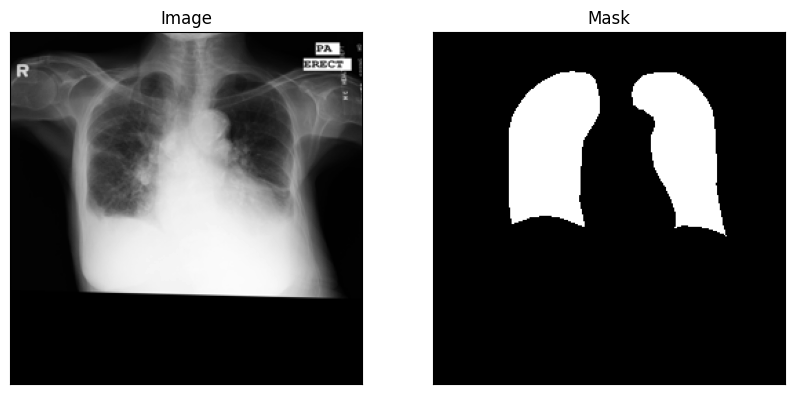

In [ ]:
import random  # Import the random module
import matplotlib.pyplot as plt
import numpy as np

img_num = random.randint(0, len(dataset)-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()